In [32]:
multi_sentence_text = """The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.

Key Aspects of the Monte Carlo Algorithm:
Random Sampling: The core idea is to generate random variables to simulate complex systems or processes. The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.

Estimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results. These results tend to get more accurate as the number of trials increases (according to the law of large numbers).

Applications:

Numerical Integration: When integrals are difficult to evaluate analytically, Monte Carlo methods approximate them by averaging sampled values.
Optimization: Used in scenarios like stochastic optimization, where exact solutions are hard to compute.
Statistical Inference: Monte Carlo is used in Bayesian inference to estimate posterior distributions.
Simulations: For example, in finance to model stock prices or risks.
Basic Process:
Define a Problem: The first step is to define a domain of possible inputs (often high-dimensional and complex).

Generate Random Samples: Randomly generate inputs from a probability distribution over the domain.

Compute Results: Evaluate the function or process for each randomly generated input.

Average the Results: Use the results to compute an average or distribution of outputs, which serves as the approximation to the problem.

Example: Estimating Pi
A common example is using the Monte Carlo method to estimate Pi:

Consider a circle of radius 1 inside a square with sides of length 2.
Generate random points in the square.
The ratio of points that fall inside the circle to the total number of points is approximately Pi/4. By multiplying this ratio by 4, you can estimate the value of Pi.
Advantages:
Scalability: Works well with problems of high-dimensional spaces.
Simplicity: The algorithm is easy to implement and doesn't require detailed knowledge of the problem.
Flexibility: It can be applied to a wide range of problems where deterministic solutions are not feasible.
Disadvantages:
Convergence Time: The algorithm may require a large number of samples to converge to an accurate solution, which can be computationally expensive.
Accuracy: As it is based on random sampling, the result is an approximation and not an exact answer.
Monte Carlo algorithms are especially useful in scenarios where exact mathematical modeling is difficult or impossible, but simulation can provide insights or approximate solutions."""

In [33]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter_r = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap= 100
)
sentences = splitter_r.split_text(multi_sentence_text)

data = {i+1: sentence for i, sentence in enumerate(sentences)}

for sentence in data.items():
    print(f"{sentence}")


(1, 'The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.')
(2, 'Key Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes. The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.')
(3, 'Estimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results. These results tend to get more accurate as the number of trials increases (according to the law of large numbers).\n\nApplications:')
(4, 'Numerical Integration: When integrals are difficult to evaluate analytically, Monte Carlo m

In [34]:
import numpy as np
from functools import singledispatchmethod
from copy import copy
import re

from abc import ABC, abstractmethod


def find_end_of_sentence(text, start):
    end = start
    while end < len(text) and text[end] not in '.!?':
        end += 1
    return end


class AbstractSplitter(ABC):
    """ This is how DRY dies, with thunderous applaus of abstract OOP """
    @abstractmethod
    def split(self, data, chunk_size, overlap, margin):
        pass

    @singledispatchmethod
    @abstractmethod
    def _overlap_splits_dispatcher(self, overlap, data_size, chunk_size):
        pass
    
    @singledispatchmethod
    @abstractmethod
    def _split_dispatcher(self, overlap, data, chunk_size, margin):
        pass


class TextSplitter(AbstractSplitter):
    white_space_pattern = re.compile('\s')

    @staticmethod
    def splits(text_length, chunk_size):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size)

    @staticmethod
    def _overlap_splits(text_length, chunk_size, overlap):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size-overlap)
    
    @singledispatchmethod
    def _split_dispatcher(self, overlap, text, chunk_size, margin):
        raise ValueError(f"Invalid overlap type: {type(overlap)}")
    
    @singledispatchmethod
    def _overlap_splits_dispatcher(self, margin, overlap, data_size, chunk_size):
        raise ValueError(f"Invalid overlap type: {type(margin)}")
    
    @_overlap_splits_dispatcher.register
    def _(self, margin: None, overlap: int, data_size, chunk_size):
        return TextSplitter.overlap_splits(data_size, chunk_size, overlap)

    @_overlap_splits_dispatcher.register
    def _(self, margin: int, overlap: int, data_size, chunk_size):
        overlaps = []

    @_split_dispatcher.register
    def _(self, overlap: int, text, chunk_size, margin):
        max_chunk_size = chunk_size - overlap
        remaining_text = copy(text)
        
        split_positions = []
        text_length = len(remaining_text)
        static_split_pos = text_length - max_chunk_size
        positive_margin_subset = text[static_split_pos:static_split_pos+margin]
        new_pos = self.split_pos(positive_margin_subset, static_split_pos)
        split_positions.insert(0, (new_pos, len(remaining_text)))
        remaining_text = remaining_text[:new_pos]
        while True:
            text_length = len(remaining_text)
            static_split_pos = text_length - max_chunk_size
            negative_margin_subset = remaining_text[text_length-margin:]
            new_neg_pos = self.split_neg(negative_margin_subset, text_length)

            positive_margin_subset = text[static_split_pos:static_split_pos+margin]
            new_pos = self.split_pos(positive_margin_subset, static_split_pos)
            split_positions.insert(0, (new_pos, new_neg_pos))
            remaining_text = remaining_text[:new_pos]
            
            if len(remaining_text) < max_chunk_size:
                break
        
        split_positions.insert(0, (0, len(remaining_text)+overlap))

        return {k:text[i:j] for k, (i, j) in enumerate(split_positions)}

    @_split_dispatcher.register
    def _(self, overlap: None, text, chunk_size, margin):
        split_pos = self.splits(len(text), chunk_size)
        split_pos = np.insert(split_pos, 0, 0)
        return {key:text[i:i+chunk_size] for key, i in enumerate(split_pos)}
    
    @_split_dispatcher.register
    def _(self, overlap: float, text, chunk_size, margin):
        return self.overlap_splits(len(text), chunk_size, int(chunk_size*overlap))
    
    def split_pos(self, string, current_position):
        for i, letter in enumerate(string):
            if letter == '.':
                return current_position + i + 1

        for i, letter in enumerate(string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position + i + 1
            
        return current_position
    
    
    def split_neg(self, string, current_position):
        inv_string = string[::-1]
        for i, letter in enumerate(inv_string):
            if letter == '.':
                return current_position - i

        for i, letter in enumerate(inv_string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position - i
            
        return current_position

    def split(self, text, chunk_size=100, overlap: None = None, margin: int = 10):
        return self._split_dispatcher(overlap, text, chunk_size, margin)
    
    def overlap_splits(self, text_length, chunk_size, overlap, margin=None):
        return self._overlap_splits_dispatcher(margin, overlap, text_length, chunk_size)


ts = TextSplitter()
ts.split(multi_sentence_text, 500, 100, 400)


{0: 'The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems',
 1: ' These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.\n\nKey Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes.',
 2: ' The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.\n\nEstimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results.',
 3: ' These results tend to get more accurate as the number of trials increases (according to the law of large numbers).

In [35]:
from time import time_ns


start_time = time_ns()
[splitter_r.split_text(multi_sentence_text) for _ in range(0, 100000)]
print(f"Time needed for execution: {time_ns()-start_time}")

start_time = time_ns()
[ts.split(multi_sentence_text, 500, 100, 20) for _ in range(0, 100000)]
print(f"Time needed for execution: {time_ns()-start_time}")

Time needed for execution: 2767674300
Time needed for execution: 1804658100


In [36]:
result_lang = splitter_r.split_text(multi_sentence_text)
print(result_lang)
print("Langchain Splitter")
for i, sentence in enumerate(result_lang):
    print(f"#{i+1}: {len(sentence)}")

result_custom = ts.split(multi_sentence_text, 500, 100, 100)

print("Custom Splitter")
for i, sentence in enumerate(result_custom.values()):
    print(f"#{i+1}: {len(sentence)}")

['The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.', 'Key Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes. The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.', 'Estimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results. These results tend to get more accurate as the number of trials increases (according to the law of large numbers).\n\nApplications:', 'Numerical Integration: When integrals are difficult to evaluate analytically, Monte Carlo methods approxim

In [37]:
import numpy as np
from functools import singledispatchmethod
from copy import copy
import re

from abc import ABC, abstractmethod


def find_end_of_sentence(text, start):
    end = start
    while end < len(text) and text[end] not in '.!?':
        end += 1
    return end


class AbstractSplitter(ABC):
    """ This is how DRY dies, with thunderous applaus of abstract OOP """
    @abstractmethod
    def split(self, data, chunk_size, overlap, margin):
        pass

    @singledispatchmethod
    @abstractmethod
    def _overlap_splits_dispatcher(self, overlap, data_size, chunk_size):
        pass
    
    @singledispatchmethod
    @abstractmethod
    def _split_dispatcher(self, overlap, data, chunk_size, margin):
        pass


class TextSplitter(AbstractSplitter):
    white_space_pattern = re.compile('\s')

    @staticmethod
    def splits(text_length, chunk_size):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size)

    @staticmethod
    def _overlap_splits(text_length, chunk_size, overlap):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size-overlap)
    
    @singledispatchmethod
    def _split_dispatcher(self, overlap, text, chunk_size, margin):
        raise ValueError(f"Invalid overlap type: {type(overlap)}")
    
    @singledispatchmethod
    def _overlap_splits_dispatcher(self, margin, overlap, data_size, chunk_size):
        raise ValueError(f"Invalid overlap type: {type(margin)}")
    
    @_overlap_splits_dispatcher.register
    def _(self, margin: None, overlap: int, data_size, chunk_size):
        return TextSplitter.overlap_splits(data_size, chunk_size, overlap)

    @_overlap_splits_dispatcher.register
    def _(self, margin: int, overlap: int, data_size, chunk_size):
        overlaps = []

    @_split_dispatcher.register
    def _(self, overlap: int, text, chunk_size, margin):
        max_chunk_size = chunk_size - overlap
        remaining_text = copy(text)
        
        split_positions = []
        text_length = len(remaining_text)
        static_split_pos = text_length - max_chunk_size
        positive_margin_subset = text[static_split_pos:static_split_pos+margin]
        new_pos = self.split_pos(positive_margin_subset, static_split_pos)
        split_positions.insert(0, (new_pos, len(remaining_text)))
        remaining_text = remaining_text[:new_pos]
        while True:
            text_length = len(remaining_text)
            static_split_pos = text_length - max_chunk_size
            negative_margin_subset = remaining_text[text_length-margin:]
            new_neg_pos = self.split_neg(negative_margin_subset, text_length)

            positive_margin_subset = text[static_split_pos:static_split_pos+margin]
            new_pos = self.split_pos(positive_margin_subset, static_split_pos)
            split_positions.insert(0, (new_pos, new_neg_pos))
            remaining_text = remaining_text[:new_pos]
            
            if len(remaining_text) < max_chunk_size:
                break
        
        split_positions.insert(0, (0, len(remaining_text)+overlap))

        return {k:text[i:j] for k, (i, j) in enumerate(split_positions)}

    @_split_dispatcher.register
    def _(self, overlap: None, text, chunk_size, margin):
        split_pos = self.splits(len(text), chunk_size)
        split_pos = np.insert(split_pos, 0, 0)
        return {key:text[i:i+chunk_size] for key, i in enumerate(split_pos)}
    
    @_split_dispatcher.register
    def _(self, overlap: float, text, chunk_size, margin):
        return self.overlap_splits(len(text), chunk_size, int(chunk_size*overlap))
    
    def split_pos(self, string, current_position):
        for i, letter in enumerate(string):
            if letter == '.':
                return current_position + i + 1

        for i, letter in enumerate(string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position + i + 1
            
        return current_position
    
    
    def split_neg(self, string, current_position):
        inv_string = string[::-1]
        for i, letter in enumerate(inv_string):
            if letter == '.':
                return current_position - i

        for i, letter in enumerate(inv_string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position - i
            
        return current_position

    def split(self, text, chunk_size=100, overlap: None = None, margin: int = 10):
        return self._split_dispatcher(overlap, text, chunk_size, margin)
    
    def overlap_splits(self, text_length, chunk_size, overlap, margin=None):
        return self._overlap_splits_dispatcher(margin, overlap, text_length, chunk_size)


ts = TextSplitter()
ts.split(multi_sentence_text, 500, 100, 400)

{0: 'The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems',
 1: ' These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.\n\nKey Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes.',
 2: ' The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.\n\nEstimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results.',
 3: ' These results tend to get more accurate as the number of trials increases (according to the law of large numbers).

In [38]:
import numpy as np
from functools import singledispatchmethod
from copy import copy
import re

from abc import ABC, abstractmethod


def find_end_of_sentence(text, start):
    end = start
    while end < len(text) and text[end] not in '.!?':
        end += 1
    return end


class AbstractSplitter(ABC):
    """ This is how DRY dies, with thunderous applaus of abstract OOP """
    @abstractmethod
    def split(self, data, chunk_size, overlap, margin):
        pass

    @singledispatchmethod
    @abstractmethod
    def _overlap_splits_dispatcher(self, overlap, data_size, chunk_size):
        pass
    
    @singledispatchmethod
    @abstractmethod
    def _split_dispatcher(self, overlap, data, chunk_size, margin):
        pass


class AltTextSplitter(AbstractSplitter):
    white_space_pattern = re.compile('\s')

    @staticmethod
    def splits(text_length, chunk_size):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size)

    @staticmethod
    def _overlap_splits(text_length, chunk_size, overlap):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size-overlap)
    
    @singledispatchmethod
    def _split_dispatcher(self, overlap, text, chunk_size, margin):
        raise ValueError(f"Invalid overlap type: {type(overlap)}")
    
    @singledispatchmethod
    def _overlap_splits_dispatcher(self, margin, overlap, data_size, chunk_size):
        raise ValueError(f"Invalid overlap type: {type(margin)}")
    
    @_overlap_splits_dispatcher.register
    def _(self, margin: None, overlap: int, data_size, chunk_size):
        return TextSplitter.overlap_splits(data_size, chunk_size, overlap)

    @_overlap_splits_dispatcher.register
    def _(self, margin: int, overlap: int, data_size, chunk_size):
        overlaps = []

    @_split_dispatcher.register
    def _(self, overlap: int, text, chunk_size, margin):
        max_chunk_size = chunk_size - overlap
        remaining_text_length = len(text)
        
        static_split_pos = remaining_text_length - max_chunk_size
        positive_margin_subset = text[static_split_pos:static_split_pos+margin]
        new_pos = self.split_pos(positive_margin_subset, static_split_pos)
        split_positions = [text[new_pos:remaining_text_length]]
        remaining_text_length = remaining_text_length - (remaining_text_length-new_pos)
        while True:
            static_split_pos = remaining_text_length - max_chunk_size
            negative_margin_subset = text[remaining_text_length-margin:remaining_text_length]
            new_neg_pos = self.split_neg(negative_margin_subset, remaining_text_length)

            positive_margin_subset = text[static_split_pos:static_split_pos+margin]
            new_pos = self.split_pos(positive_margin_subset, static_split_pos)
            split_positions.append(text[new_pos:new_neg_pos])
            remaining_text_length = remaining_text_length - (remaining_text_length-new_pos)
            
            if remaining_text_length < max_chunk_size:
                break
        
        split_positions.append(text[0:remaining_text_length+overlap])
        # split_positions = split_positions[::-1]

        return split_positions

    @_split_dispatcher.register
    def _(self, overlap: None, text, chunk_size, margin):
        split_pos = self.splits(len(text), chunk_size)
        split_pos = np.insert(split_pos, 0, 0)
        return {key:text[i:i+chunk_size] for key, i in enumerate(split_pos)}
    
    @_split_dispatcher.register
    def _(self, overlap: float, text, chunk_size, margin):
        return self.overlap_splits(len(text), chunk_size, int(chunk_size*overlap))
    
    def split_pos(self, string, current_position):
        for i, letter in enumerate(string):
            if letter == '.':
                return current_position + i + 1

        for i, letter in enumerate(string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position + i + 1
            
        return current_position
    
    
    def split_neg(self, string, current_position):
        inv_string = string[::-1]
        for i, letter in enumerate(inv_string):
            if letter == '.':
                return current_position - i

        for i, letter in enumerate(inv_string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position - i
            
        return current_position

    def split(self, text, chunk_size=100, overlap: None = None, margin: int = 10):
        return self._split_dispatcher(overlap, text, chunk_size, margin)
    
    def overlap_splits(self, text_length, chunk_size, overlap, margin=None):
        return self._overlap_splits_dispatcher(margin, overlap, text_length, chunk_size)


ts = AltTextSplitter()
ts.split(multi_sentence_text, 500, 100, 400)


['\nAccuracy: As it is based on random sampling, the result is an approximation and not an exact answer.\nMonte Carlo algorithms are especially useful in scenarios where exact mathematical modeling is difficult or impossible, but simulation can provide insights or approximate solutions.',
 "\nSimplicity: The algorithm is easy to implement and doesn't require detailed knowledge of the problem.\nFlexibility: It can be applied to a wide range of problems where deterministic solutions are not feasible.\nDisadvantages:\nConvergence Time: The algorithm may require a large number of samples to converge to an accurate solution, which can be computationally expensive.",
 '\nGenerate random points in the square.\nThe ratio of points that fall inside the circle to the total number of points is approximately Pi/4. By multiplying this ratio by 4, you can estimate the value of Pi.\nAdvantages:\nScalability: Works well with problems of high-dimensional spaces.',
 '\n\nCompute Results: Evaluate the fu

In [39]:
large_text = " ".join([multi_sentence_text for _ in range(0, 150)])

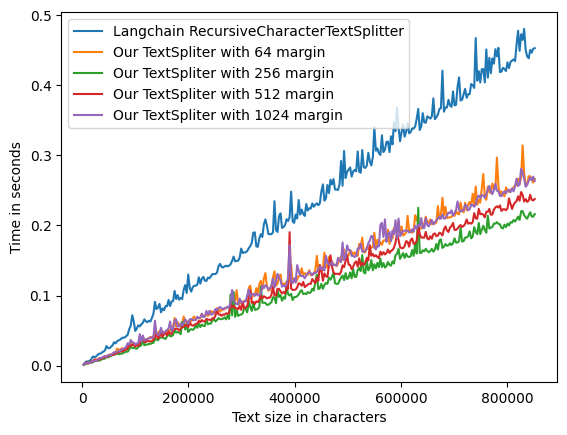

In [40]:
import matplotlib.pyplot as plt

splitter_r = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap= 256
)
splitter_c = CharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap= 256
)
ts = TextSplitter()
ats = AltTextSplitter()

times_lang_r = []
times_custom_1 = []
times_custom_2 = []
times_custom_3 = []
times_custom_4 = []
for i in range(1, 300):
    large_text = " ".join([multi_sentence_text for _ in range(0, i)])
    start_time = time()
    [splitter_r.split_text(large_text) for _ in range(0, 100)]
    exec_time_lang_r = time()-start_time

    start_time = time()
    [ats.split(large_text, 1024, 256, 64) for _ in range(0, 100)]
    exec_time_custom_1 = time()-start_time

    start_time = time()
    [ats.split(large_text, 1024, 256, 256) for _ in range(0, 100)]
    exec_time_custom_2 = time()-start_time

    start_time = time()
    [ats.split(large_text, 1024, 256, 512) for _ in range(0, 100)]
    exec_time_custom_3 = time()-start_time

    start_time = time()
    [ats.split(large_text, 1024, 256, 1024) for _ in range(0, 100)]
    exec_time_custom_4 = time()-start_time

    times_lang_r.append(exec_time_lang_r)
    times_custom_1.append(exec_time_custom_1)
    times_custom_2.append(exec_time_custom_2)
    times_custom_3.append(exec_time_custom_3)
    times_custom_4.append(exec_time_custom_4)

text_size = len(multi_sentence_text)

plot = plt.figure()
plt.plot(range(text_size, 300*text_size, text_size), times_lang_r, label="Langchain RecursiveCharacterTextSplitter")
plt.plot(range(text_size, 300*text_size, text_size), times_custom_1, label="Our TextSpliter with 64 margin")
plt.plot(range(text_size, 300*text_size, text_size), times_custom_2, label="Our TextSpliter with 256 margin")
plt.plot(range(text_size, 300*text_size, text_size), times_custom_3, label="Our TextSpliter with 512 margin")
plt.plot(range(text_size, 300*text_size, text_size), times_custom_4, label="Our TextSpliter with 1024 margin")
plt.xlabel("Text size in characters")
plt.ylabel("Time in seconds")
plt.legend()

In [43]:
import plotly
import plotly.graph_objs as go

plt = go.Figure()

plt.add_trace(go.Scatter(
    x=list(range(text_size, 300*text_size, text_size)),
    y=times_lang_r,
    mode="lines",
    name="Langchain RecursiveCharacterTextSplitter"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 300*text_size, text_size)),
    y=times_custom_1,
    mode="lines",
    name="Our TextSpliter with 64 margin"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 300*text_size, text_size)),
    y=times_custom_2,
    mode="lines",
    name="Our TextSpliter with 256 margin"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 300*text_size, text_size)),
    y=times_custom_3,
    mode="lines",
    name="Our TextSpliter with 512 margin"
))

plt.add_trace(go.Scatter(
    x=list(range(text_size, 300*text_size, text_size)),
    y=times_custom_4,
    mode="lines",
    name="Our TextSpliter with 1024 margin"
))

plt.update_layout(
    title="Execution time of text splitters",
    xaxis_title="Text size in characters",
    yaxis_title="Time in seconds",
    template="plotly_dark",
    legend=dict(
        x=0.01,
        y=0.99
    )
)

plt.show()

In [42]:
import numpy as np
from functools import singledispatchmethod
from copy import copy
import re

from abc import ABC, abstractmethod


def find_end_of_sentence(text, start):
    end = start
    while end < len(text) and text[end] not in '.!?':
        end += 1
    return end


class AbstractSplitter(ABC):
    """ This is how DRY dies, with thunderous applaus of abstract OOP """
    @abstractmethod
    def split(self, data, chunk_size, overlap, margin):
        pass

    @singledispatchmethod
    @abstractmethod
    def _overlap_splits_dispatcher(self, overlap, data_size, chunk_size):
        pass
    
    @singledispatchmethod
    @abstractmethod
    def _split_dispatcher(self, overlap, data, chunk_size, margin):
        pass


class TextSplitter(AbstractSplitter):
    white_space_pattern = re.compile('\s')

    @staticmethod
    def splits(text_length, chunk_size):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size)

    @staticmethod
    def _overlap_splits(text_length, chunk_size, overlap):
        return np.arange(chunk_size, text_length-chunk_size+1, chunk_size-overlap)
    
    @singledispatchmethod
    def _split_dispatcher(self, overlap, text, chunk_size, margin):
        raise ValueError(f"Invalid overlap type: {type(overlap)}")
    
    @singledispatchmethod
    def _overlap_splits_dispatcher(self, margin, overlap, data_size, chunk_size):
        raise ValueError(f"Invalid overlap type: {type(margin)}")
    
    @_overlap_splits_dispatcher.register
    def _(self, margin: None, overlap: int, data_size, chunk_size):
        return TextSplitter.overlap_splits(data_size, chunk_size, overlap)

    @_overlap_splits_dispatcher.register
    def _(self, margin: int, overlap: int, data_size, chunk_size):
        overlaps = []

    @_split_dispatcher.register
    def _(self, overlap: int, text, chunk_size, margin):
        max_chunk_size = chunk_size - overlap
        remaining_text = copy(text)
        
        split_positions = []
        text_length = len(remaining_text)
        static_split_pos = text_length - max_chunk_size
        positive_margin_subset = text[static_split_pos:static_split_pos+margin]
        new_pos = self.split_pos(positive_margin_subset, static_split_pos)
        split_positions.insert(0, (new_pos, len(remaining_text)))
        remaining_text = remaining_text[:new_pos]
        while True:
            text_length = len(remaining_text)
            static_split_pos = text_length - max_chunk_size
            negative_margin_subset = remaining_text[text_length-margin:]
            new_neg_pos = self.split_neg(negative_margin_subset, text_length)

            positive_margin_subset = text[static_split_pos:static_split_pos+margin]
            new_pos = self.split_pos(positive_margin_subset, static_split_pos)
            split_positions.insert(0, (new_pos, new_neg_pos))
            remaining_text = remaining_text[:new_pos]
            
            if len(remaining_text) < max_chunk_size:
                break
        
        split_positions.insert(0, (0, len(remaining_text)+overlap))

        return {k:text[i:j] for k, (i, j) in enumerate(split_positions)}

    @_split_dispatcher.register
    def _(self, overlap: None, text, chunk_size, margin):
        split_pos = self.splits(len(text), chunk_size)
        split_pos = np.insert(split_pos, 0, 0)
        return {key:text[i:i+chunk_size] for key, i in enumerate(split_pos)}
    
    @_split_dispatcher.register
    def _(self, overlap: float, text, chunk_size, margin):
        return self.overlap_splits(len(text), chunk_size, int(chunk_size*overlap))
    
    def split_pos(self, string, current_position):
        for i, letter in enumerate(string):
            if letter == '.':
                return current_position + i + 1

        for i, letter in enumerate(string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position + i + 1
            
        return current_position
    
    
    def split_neg(self, string, current_position):
        inv_string = string[::-1]
        for i, letter in enumerate(inv_string):
            if letter == '.':
                return current_position - i

        for i, letter in enumerate(inv_string):
            if not isinstance(self.white_space_pattern.match(letter), type(None)):
                return current_position - i
            
        return current_position

    def split(self, text, chunk_size=100, overlap: None = None, margin: int = 10):
        return self._split_dispatcher(overlap, text, chunk_size, margin)
    
    def overlap_splits(self, text_length, chunk_size, overlap, margin=None):
        return self._overlap_splits_dispatcher(margin, overlap, text_length, chunk_size)


ts = TextSplitter()
ts.split(multi_sentence_text, 500, 100, 400)


{0: 'The Monte Carlo algorithm (or Monte Carlo method) refers to a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. These methods are used in various fields such as finance, physics, engineering, and AI for problems',
 1: ' These methods are used in various fields such as finance, physics, engineering, and AI for problems that are deterministic in principle but difficult to solve directly.\n\nKey Aspects of the Monte Carlo Algorithm:\nRandom Sampling: The core idea is to generate random variables to simulate complex systems or processes.',
 2: ' The algorithm uses probabilistic models and generates numerous random samples to approximate the solution to a deterministic problem.\n\nEstimation of Results: Monte Carlo methods provide estimates of the outcome by running many simulations and averaging the results.',
 3: ' These results tend to get more accurate as the number of trials increases (according to the law of large numbers).